## Import

Imports required packages and data. The data comes from a log file which records the Hive Thermostat data every 15 minutes using the `pyhiveapi` package to access the Hive API. This is done by the `hivelog.py` script.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

from meteostat import Point, Hourly

file = "hivelog.csv"
data = pd.read_csv(file)

data

,Date,Time,HeatingStatus,CurrentTemperature,SetTemperature
0,27/04/2021,17:11:24,ON,18.3,19.0
1,27/04/2021,17:33:59,ON,18.8,19.0
2,27/04/2021,18:04:28,OFF,19.2,19.0
3,27/04/2021,18:21:28,OFF,19.3,19.0
4,27/04/2021,18:34:43,OFF,19.2,19.0
...,...,...,...,...,...
4649,15/06/2021,16:00:08,OFF,22.4,18.0
4650,15/06/2021,16:15:05,OFF,22.4,18.0
4651,15/06/2021,16:30:06,OFF,22.5,18.0
4652,15/06/2021,16:45:05,OFF,22.5,18.0


## Prepare data

Prepares data (creates timestamp)

In [2]:

timestamp = data['Date'] + ' ' + data['Time']
timestamp = pd.to_datetime(timestamp, dayfirst=True)
timestamp.rename(index = 'Timestamp', inplace=True)
data = pd.concat([data, timestamp], axis = 1)
data.drop(columns=['Date','Time'], inplace = True)
#data.loc[data['HeatingStatus'] == 'ON', 'HeatingStatus'] = 1
#data.loc[data['HeatingStatus'] == 'OFF', 'HeatingStatus'] = 0
data.set_index('Timestamp', inplace=True)

data

,HeatingStatus,CurrentTemperature,SetTemperature
Timestamp,,,
2021-04-27 17:11:24,ON,18.3,19.0
2021-04-27 17:33:59,ON,18.8,19.0
2021-04-27 18:04:28,OFF,19.2,19.0
2021-04-27 18:21:28,OFF,19.3,19.0
2021-04-27 18:34:43,OFF,19.2,19.0
...,...,...,...
2021-06-15 16:00:08,OFF,22.4,18.0
2021-06-15 16:15:05,OFF,22.4,18.0
2021-06-15 16:30:06,OFF,22.5,18.0


## Weather data

Uses `meteostat` package to fetch historical weather data if it has not been done yet.

In [3]:
def fetch_meteo(): 
    start = datetime(2021, 4, 27)
    end = datetime.now()
    location = Point(55.92868, -3.17668,67)
    meteo_data = Hourly(location, start, end)
    meteo_data = meteo_data.normalize()
    meteo_data = meteo_data.interpolate()
    meteo_data = meteo_data.fetch()
    return meteo_data

try:
    meteo_data
except NameError:
    meteo_data = fetch_meteo()
    
meteo_data 

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2021-04-27 00:00:00,6.8,5.7,93.0,0.1,NaN,240.0,11.2,20.4,1011.0,NaN,4.0
2021-04-27 01:00:00,6.8,5.7,93.0,0.0,NaN,250.0,7.6,18.5,1011.0,NaN,4.0
2021-04-27 02:00:00,6.8,5.7,93.0,0.0,NaN,260.0,7.6,16.7,1010.0,NaN,4.0
2021-04-27 03:00:00,6.8,4.8,87.0,0.0,NaN,270.0,3.6,14.8,1010.0,NaN,4.0
2021-04-27 04:00:00,5.8,4.8,93.0,0.4,NaN,260.0,1.8,13.0,1010.0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16 06:00:00,13.8,11.7,87.0,0.1,NaN,222.0,22.2,33.3,1008.0,NaN,7.0
2021-06-16 07:00:00,13.8,11.5,86.0,0.3,NaN,222.0,22.2,35.2,1008.2,NaN,7.0
2021-06-16 08:00:00,13.9,11.1,83.0,0.2,NaN,223.0,22.2,35.2,1008.3,NaN,7.0


## Interpolate temperature data

Adds an outdoor temperature column to heating data based on closest timepoint from historical weather data. This is not necessary for plotting (two plots with different sampling points can be plotted on the same datetime axis without issues), however it adds an interesting metric for further analysis.

In [4]:
closest_temp = []
for row in data.itertuples():
    closest_temp.append(float(meteo_data[(timedelta(minutes=-30) < meteo_data.index - row[0]) & (meteo_data.index - row[0] <= timedelta(minutes=30))]['temp'].values))
data['OutTemp'] = closest_temp

data


,HeatingStatus,CurrentTemperature,SetTemperature,OutTemp
Timestamp,,,,
2021-04-27 17:11:24,ON,18.3,19.0,6.8
2021-04-27 17:33:59,ON,18.8,19.0,6.8
2021-04-27 18:04:28,OFF,19.2,19.0,6.8
2021-04-27 18:21:28,OFF,19.3,19.0,6.8
2021-04-27 18:34:43,OFF,19.2,19.0,5.8
...,...,...,...,...
2021-06-15 16:00:08,OFF,22.4,18.0,16.8
2021-06-15 16:15:05,OFF,22.4,18.0,16.8
2021-06-15 16:30:06,OFF,22.5,18.0,15.5


## Functions

Defines functions that can be used to plot the temperature data over time and calculate heating length.

The `plotter` function takes the following optional arguments:   
month: *int, default None* - month number for which to plot data, otherwise all data is plotted  
outdoor: *bool, default False* - True plots outside temperature  
heating: *bool, default False* - True shows when heating was on   

The `heating_length` calculates and prints the duration the heating was on for. It also has the optional month argument.

In [5]:
def plotter(data, month=None, outdoor=False,heating = False):
    if month is not None:
        monthDict={1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
        monthName = monthDict[month]
        data = data[(datetime(2021, month, 1) <= data.index) &  (data.index < datetime(2021, month+1, 1))]
    
    settemp = data['SetTemperature']
    curtemp = data['CurrentTemperature']
    status = data['HeatingStatus']
    
    fig1, ax = plt.subplots(figsize=[12,6])
    ax.plot(data.index,curtemp,'r',label='Actual temperature')
    ax.plot(data.index,settemp,'g--',alpha=0.3, label = 'Target temperature')
    
    if outdoor  == True:
        ax.plot(data.index,data['OutTemp'], 'b', alpha = 0.4, label = 'Outdoor temperature')
        ax.set_ylim(min(data['OutTemp'])-1,max(curtemp)*1.05)

    if heating == True:
        plt.vlines(status.index[status == 'ON'], -5, 30, colors='orange', alpha=0.3, label = 'Heating ON')
        
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(min(settemp)*.9,max(curtemp)*1.05)
    ax.set_xlim(data.index[0]-timedelta(seconds=15*60),data.index[-1])
    ax.set_ylabel('Temperature / °C')
    ax.set_xlabel('Date')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=8))
    ax.legend(loc=8)
    
    if month is not None:
        ax.set_title('Heating data for ' + monthName + ' .')
    else:
        ax.set_title('Heating data over time')
    return

def heating_length(data, month=None):
    if month is not None:
        monthDict={1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
        monthName = monthDict[month]
        data = data[(datetime(2021, month, 1) < data.index) &  (data.index < datetime(2021, month+1, 1) - timedelta(seconds=1))]
        
    hours = sum(data['HeatingStatus'] == 'ON')/4 #data is every 15 min   
    
    if month is not None:
        print('Heating was on for ' + str(hours) + ' hours in ' + monthName +'.')
    else:
        print('Heating was on for ' + str(hours) + ' hours.')
    return


## Function examples

Below are a few examples of the two functions in action

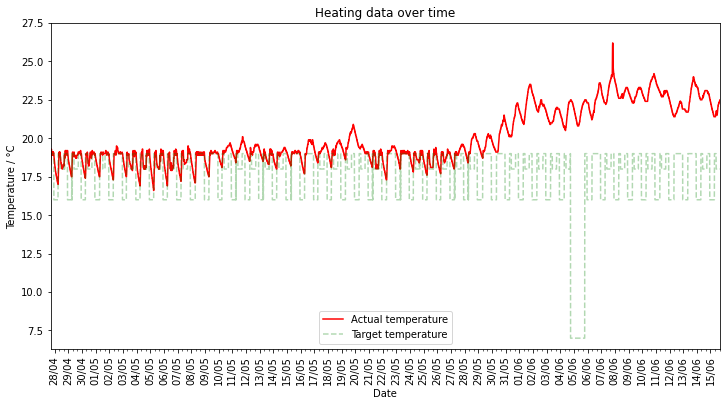

In [6]:
plotter(data) ## simplest example

Heating was on for 73.0 hours.


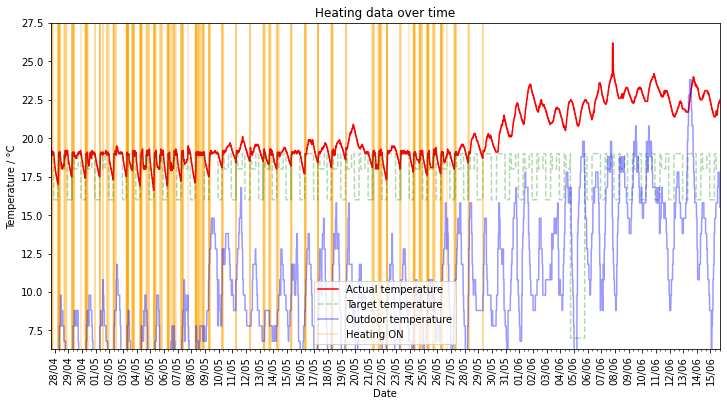

In [7]:
plotter(data,heating=True,outdoor=True) 
# shows when the heating was on (the reason I created this) and also adds historic temperature data
heating_length(data) #calculates for how long the heating has been on in total

Heating was on for 62.0 hours in May.


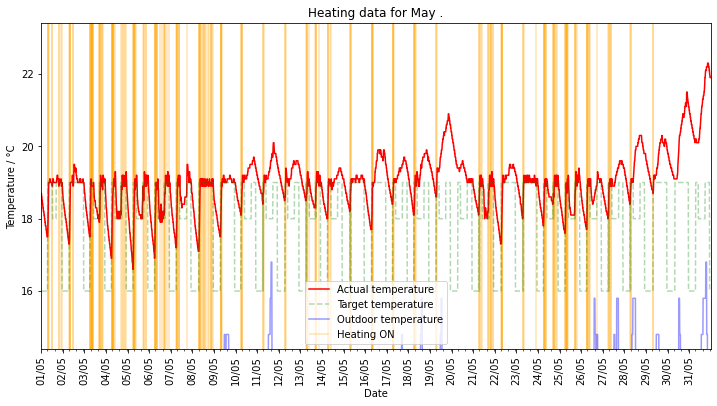

In [8]:
plotter(data,month=5,outdoor=True,heating=True) # plots data for the freakishly cold May 2021.
heating_length(data,month=5) #

## Statistics

Now that we have all this data, we can have fun with statistics. Starting with a boxplot to compare the outdoor temperature when heating is on and off.


Text(0, 0.5, 'Outside temperature / °C')

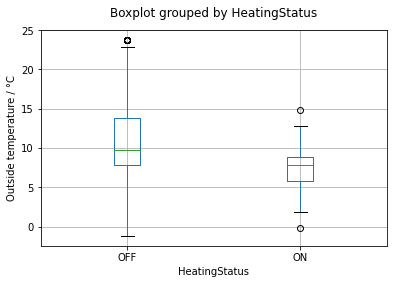

In [9]:
data.boxplot(by='HeatingStatus',column='OutTemp')
plt.title('')
plt.ylabel('Outside temperature / °C')

As expected, it looks like that the heating is on when the outside temperature is lower. Let's test this using an independent t-test.

In [10]:
stats.ttest_ind(data[data['HeatingStatus']=='ON']['OutTemp'],data[data['HeatingStatus']=='OFF']['OutTemp'],equal_var = False)

Ttest_indResult(statistic=-20.72833152287144, pvalue=2.124659417697698e-68)

Looks like the difference is extremely statistically significant! Instead of the outdoor temperature, it would also be interesting to look at the difference between the outdoor and set temperatures.

Ttest_indResult(statistic=31.379843678961684, pvalue=7.397053567307099e-119)

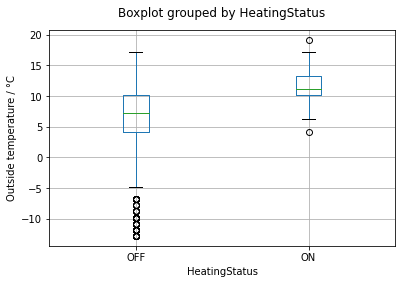

In [11]:
data['Difference'] = data['SetTemperature'] - data['OutTemp']
data.boxplot(by='HeatingStatus',column='Difference')
plt.title('')
plt.ylabel('Outside temperature / °C')
stats.ttest_ind(data[data['HeatingStatus']=='ON']['Difference'],data[data['HeatingStatus']=='OFF']['Difference'],equal_var = False)

Uh oh, looks like the OFF data is slightly skewed by the 7 °C holiday mode that was set for a weekend in June. Let's ignore those data.

Ttest_indResult(statistic=29.890331238646876, pvalue=2.0026940620631256e-108)

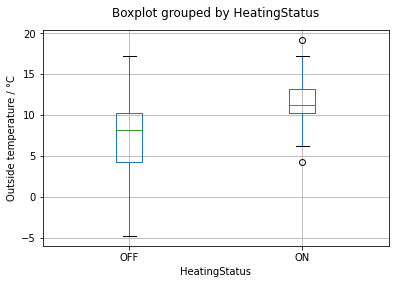

In [12]:
data_no_7 = data[data['SetTemperature'] != 7]
data_no_7.boxplot(by='HeatingStatus',column='Difference')
plt.title('')
plt.ylabel('Outside temperature / °C')
stats.ttest_ind(data_no_7[data_no_7['HeatingStatus']=='ON']['Difference'],data_no_7[data_no_7['HeatingStatus']=='OFF']['Difference'],equal_var = False)

That looks better, and even with that correction, the two groups differ significantly.  
Finally, let's just calculate some simple statistics for each month:

In [13]:
months = {4:'April',5:'May',6:'June'}
data
for month in months:
    month_data = data[(data.index >= datetime(2021,month,1)) & (data.index < datetime(2021,month+1,1))]
    heating_hours = heating_length(data,month=month) 
    for obs in ['CurrentTemperature','OutTemp','Difference']:
        mean = np.mean(month_data[obs])
        stdev = np.std(month_data[obs])
        median = np.median(month_data[obs])
        mini = min(month_data[obs])
        maxi = max(month_data[obs])
        rang = maxi-mini
        print(f'The mean {obs} was {mean:.1f} ± {stdev:.1f} °C. The median was {median:.1f} °C. \n The {obs} ranged from {mini:.1f} °C to {maxi} °C.')
    print('---')


Heating was on for 11.0 hours in April.
The mean CurrentTemperature was 18.6 ± 0.6 °C. The median was 18.8 °C. 
 The CurrentTemperature ranged from 17.0 °C to 19.3 °C.
The mean OutTemp was 5.9 ± 2.4 °C. The median was 5.8 °C. 
 The OutTemp ranged from -0.2 °C to 9.8 °C.
The mean Difference was 11.9 ± 2.1 °C. The median was 12.2 °C. 
 The Difference ranged from 8.2 °C to 19.2 °C.
---
Heating was on for 62.0 hours in May.
The mean CurrentTemperature was 19.0 ± 0.8 °C. The median was 19.0 °C. 
 The CurrentTemperature ranged from 16.6 °C to 22.3 °C.
The mean OutTemp was 8.6 ± 3.4 °C. The median was 8.8 °C. 
 The OutTemp ranged from -1.2 °C to 16.8 °C.
The mean Difference was 9.2 ± 3.0 °C. The median was 9.2 °C. 
 The Difference ranged from 1.2 °C to 17.2 °C.
---
Heating was on for 0.0 hours in June.
The mean CurrentTemperature was 22.4 ± 0.8 °C. The median was 22.4 °C. 
 The CurrentTemperature ranged from 20.5 °C to 26.2 °C.
The mean OutTemp was 14.4 ± 3.6 °C. The median was 14.8 °C. 
 The